Imports 

In [26]:
from OA_utils.OAPreprocessingScripts import *
from OA_utils.data_utils import *
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from OA_utils.eval_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from OA_lstm import LSTMModel
from OA_cnnlstm import CNNLSTMModel
from OA_lstmattn import LSTMAttentionModel
from OA_transformer import TransformerModel


Load up test patient tracking + grf data from a sample trial.

In [2]:

grf_input_path = '../Demo_data/OA1_80_1.forces'
tracking_input_path = '../Demo_data/OA1_80_1.trc'
grf_output_path = '../Demo_data/transformed/demo_forces.mot'
tracking_output_path = '../Demo_data/transformed/demo'

Preprocessing tracking + grf data

In [3]:
OA1_segs = preprocess_trc_grf(trc_ip=tracking_input_path, trc_op=tracking_output_path, 
                   markers_to_drop=[], grf_ip=grf_input_path, grf_op=grf_output_path,
                   grf_pickle_path='../Demo_data/transformed/demo_forces.pkl')

In [4]:
print(OA1_segs)

{'demo': {'left': [(1.2885, 2.0735)], 'right': [(0.6945, 1.475), (1.886, 2.696)]}}


In [5]:
#initialize arrays to store compiled segments
grf_x_segs = []
grf_y_segs = []
grf_z_segs = []


compiled_segs = {}
compiled_segs['demo'] = {
'grf_x': [], 'grf_y': [], 'grf_z': []
}
grf_path = '../Demo_data/transformed/demo_forces.pkl'
grf_df = pd.read_pickle(grf_path)
time = grf_df['time'].values

#loop thru segments and extract corresponding grf periods
for side, seg_list in OA1_segs['demo'].items():
    for (s, e) in seg_list:
        grf_mask = (time >= s) & (time <= e)
        if side == 'right':
            seg_y = grf_df.loc[grf_mask, 'ground_force_vy']
            seg_x = grf_df.loc[grf_mask, 'ground_force_vx']
            seg_z = grf_df.loc[grf_mask, 'ground_force_vz']
        else:
            seg_x = grf_df.loc[grf_mask, '1_ground_force_vx']
            seg_y = grf_df.loc[grf_mask, '1_ground_force_vy']
            seg_z = -1 * grf_df.loc[grf_mask, '1_ground_force_vz']


        subj_data = compiled_segs['demo']
        subj_data['grf_x'].append(seg_x)
        subj_data['grf_y'].append(seg_y)
        subj_data['grf_z'].append(seg_z)
                
#check how many segments we extracted (should be 3 for each grf)
num_x_segments = sum(len(data['grf_x']) for data in compiled_segs.values())
num_y_segments = sum(len(data['grf_y']) for data in compiled_segs.values())
num_z_segments = sum(len(data['grf_z']) for data in compiled_segs.values())

print(f"Number of segments (x, y, z): {num_x_segments}, {num_y_segments}, {num_z_segments}")


Number of segments (x, y, z): 3, 3, 3


Resample segments for uniform time scale

In [6]:
n_resampled_time = 100
grf_x_resampled, time_resampled = interp_segments(compiled_segs['demo']['grf_x'], n_resampled_time)
grf_y_resampled, time_resampled = interp_segments(compiled_segs['demo']['grf_y'], n_resampled_time)
grf_z_resampled, time_resampled = interp_segments(compiled_segs['demo']['grf_z'], n_resampled_time)

Visualize GRF segments

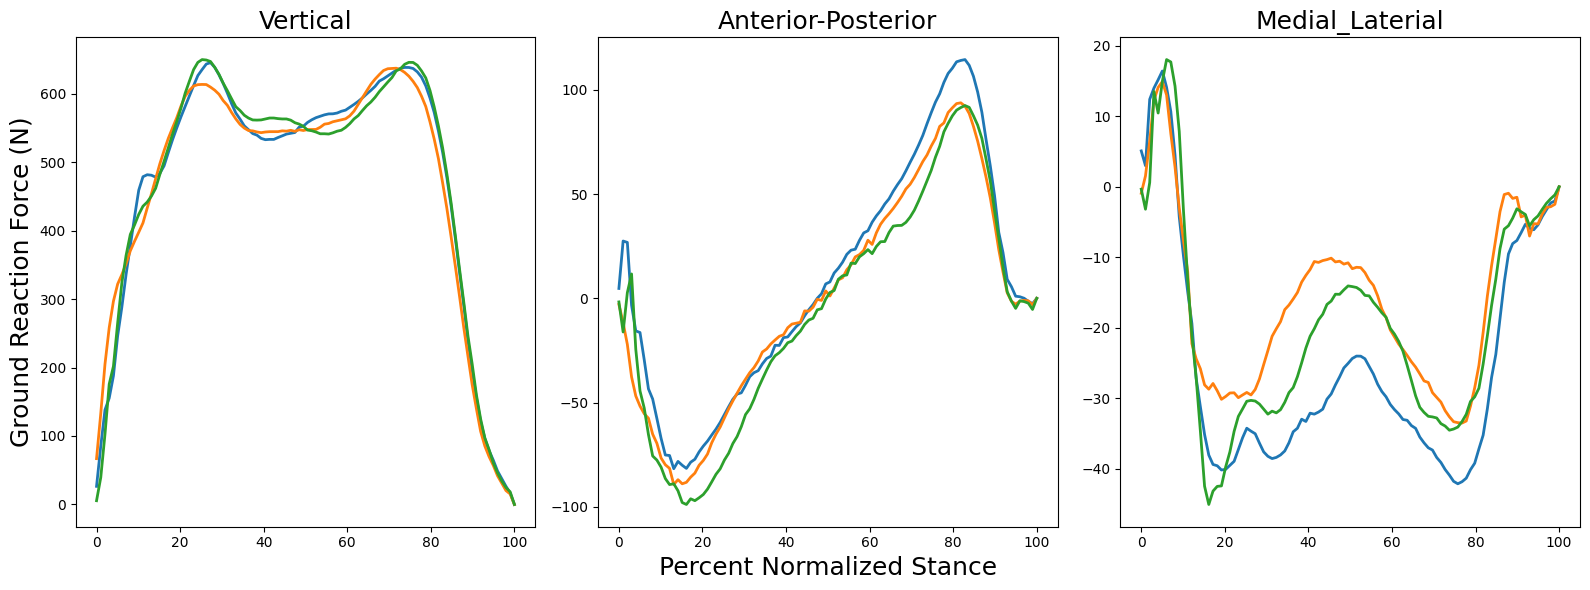

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
ax1, ax2, ax3 = axes  # unpack for readability

num_grf_segments = len(grf_x_resampled)

for i in range(num_grf_segments):
    ax1.plot(time_resampled[0] * 100, grf_y_resampled[i], linewidth=2)
    ax2.plot(time_resampled[0] * 100, grf_x_resampled[i], linewidth=2)
    ax3.plot(time_resampled[0] * 100, grf_z_resampled[i], linewidth=2)

#subplot titles
ax1.set_title('Vertical', fontsize=18)
ax2.set_title('Anterior-Posterior', fontsize=18)
ax3.set_title('Medial_Laterial', fontsize=18)

# Labels
ax1.set_ylabel("Ground Reaction Force (N)", fontsize=18)
ax2.set_xlabel("Percent Normalized Stance", fontsize=18)

plt.tight_layout()
plt.show()

Prepare grf segments for model input

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

sample_data = np.stack([
    grf_x_resampled,
    grf_y_resampled,
    grf_z_resampled
], axis = -1)
sample_tensor = torch.tensor(sample_data, dtype = torch.float32).to(device)


Device: cpu


Load up models

In [14]:
lstm_model = LSTMModel(input_size=3, 
                       hidden_size=256, 
                       num_layers=3, 
                       output_size=9, 
                       dropout=0.1002698879594955)

lstm_model.load_state_dict(torch.load('../models/Mixed_lstm.pth', map_location=device, weights_only=True))

lstm_model.to(device)

cnnlstm_model = CNNLSTMModel(input_size=3, 
                             hidden_size=256,
                             num_layers=2, 
                             output_size=9, 
                             dropout= 0.3391463727944943)

cnnlstm_model.load_state_dict(torch.load('../models/Mixed_cnn-lstm.pth', map_location=device, weights_only=True))

cnnlstm_model.to(device)

lstmattn_model = LSTMAttentionModel(input_size=3, 
                                    hidden_size=256, 
                                    num_layers=3, 
                                    num_heads=8, 
                                    output_size=9, 
                                    lstm_dropout= 0.3310440233604349, 
                                    attn_dropout= 0.1876350446397092)

lstmattn_model.load_state_dict(torch.load('../models/Mixed_lstm-attn.pth', map_location=device, weights_only=True))

lstmattn_model.to(device)

transformer_model = TransformerModel(input_dim=3,
                                     output_dim=9, 
                                     d_model=64, 
                                     nhead=4, 
                                     num_encoder_layers=4, 
                                     dim_feedforward=64, 
                                     dropout= 0.03146693103890347)

transformer_model.load_state_dict(torch.load('../models/Mixed_transformer.pth', map_location=device, weights_only=True))

transformer_model.to(device)



TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.03146693103890347, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03146693103890347, inplace=False)
        (dropout2): Dropout(p=0.03146693103890347, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=9, bias=True)
)

Get model predictions on sample data

In [17]:
lstm_pred = lstm_model(sample_tensor)
cnnlstm_pred = cnnlstm_model(sample_tensor)
lstmattn_pred = lstmattn_model(sample_tensor)
transformer_pred = transformer_model(sample_tensor)

Convert predicitons back into arrays for plotting

In [20]:
lstm_pred = lstm_pred.detach().cpu().numpy()
cnnlstm_pred = cnnlstm_pred.detach().cpu().numpy()
lstmattn_pred = lstmattn_pred.detach().cpu().numpy()
transformer_pred = transformer_pred.detach().cpu().numpy()

Visualize predicted muscle forces from each model

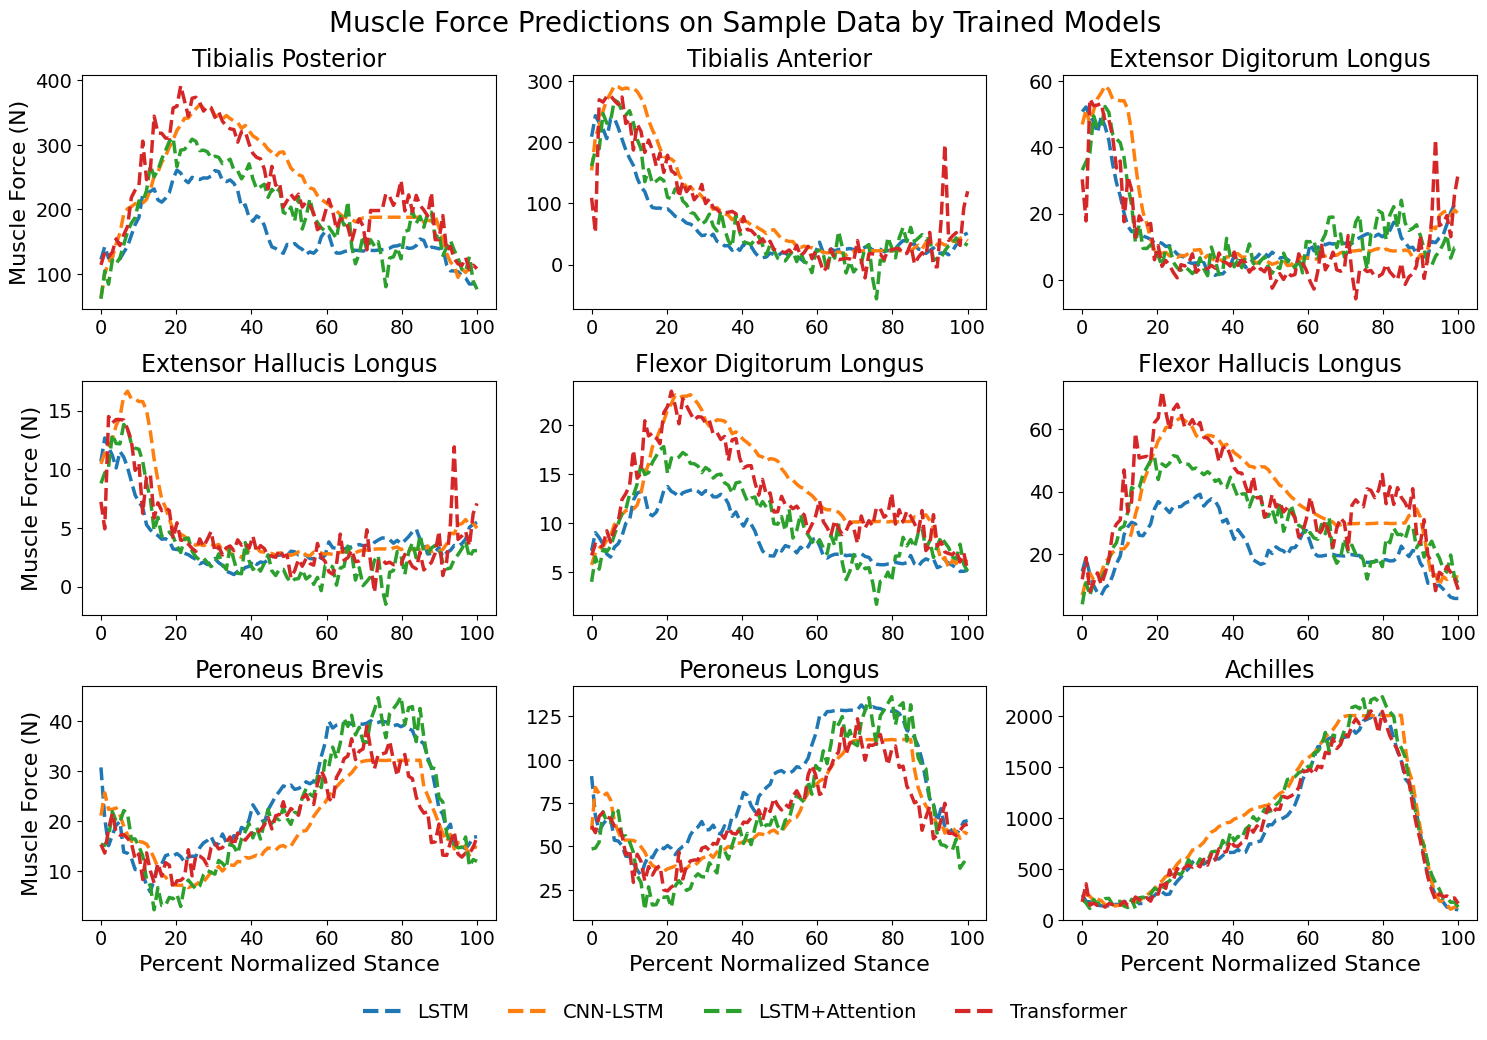

In [ ]:
muscle_titles = ['Tibialis Posterior', 'Tibialis Anterior', 'Extensor Digitorum Longus', 'Extensor Hallucis Longus', 
                 'Flexor Digitorum Longus', 'Flexor Hallucis Longus', 'Peroneus Brevis', 'Peroneus Longus', 'Achilles']
preds = [lstm_pred, cnnlstm_pred, lstmattn_pred, transformer_pred]
perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for j, ax in enumerate(axes):               # loop over muscles
    for k, pred in enumerate(preds):        # loop over models
        ax.plot(
            perc_stance,
            pred[0, :, j],
            linewidth=2.5,
            linestyle='--',
            color=colors[k]
        )

    # Axis labels
    if j >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=16)
    if j % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=16)

    ax.set_title(muscle_titles[j], fontsize=17)
    ax.tick_params(axis='both', labelsize=14)

legend_handles = [
    Line2D([0], [0], color=colors[k], linewidth=3, linestyle='--', label=model_labels[k])
    for k in range(len(model_labels))
]
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=4,
    fontsize=14,
    frameon=False,
    bbox_to_anchor=(0.5, -.05)
)
plt.suptitle('Muscle Force Predictions on Sample Data by Trained Models', fontsize=20)
plt.tight_layout()
plt.show()